#Importación Librerías


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from google.colab import drive
drive.mount('/content/drive')

path = '/content/drive/MyDrive/Proyecto Inteligencia Computacional/df_2.xlsx'
df = pd.read_excel(path)

Mounted at /content/drive


In [2]:
import itertools
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(8,8))
    plt.title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.round(cm, decimals=3)

        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')


    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.imshow(cm, interpolation='nearest', cmap=cmap)

    plt.colorbar()

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [3]:
def countFreq(arr, n):
     
    # Mark all array elements as not visited
    visited = [False for i in range(n)]
 
    # Traverse through array elements
    # and count frequencies
    for i in range(n):
         
        # Skip this element if already
        # processed
        if (visited[i] == True):
            continue
 
        # Count frequency
        count = 1
        for j in range(i + 1, n, 1):
            if (arr[i] == arr[j]):
                visited[j] = True
                count += 1
         
        print(arr[i], count)

# Tratamiento de Datos

Eliminamos las variables con mas de 150 valores nulos

In [4]:
df_copy = df.copy()
for i in df_copy:
  if df_copy[i].isna().sum() >= 150:
     df_copy = df_copy.drop(columns = [i]) 

Por lo tanto juntaremos clases las clases SNIIb, SNIIn y SNII en una sola clase puesto que tiene pocos ejemplos


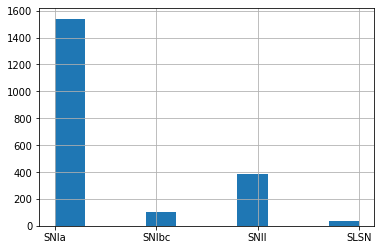

In [5]:
df_copy['classALeRCE']= df_copy['classALeRCE'].replace(['SNIIb','SNIIn'],'SNII')
df_copy['classALeRCE'].hist()
df_copy = df_copy.dropna()

Lo que podemos hacer adicionalemente es crear datasets distintos en donde se tengan sólamente 2 clases: la clase de interés y una clase que junte el resto de clases. Es por esto que podemos hacer para este caso cuatro datasets distintos. A continuación se importarán las librerías necesarias para modelar una MLP

In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE

scaler = StandardScaler()
Le = LabelEncoder()

In [7]:
#librerias necesarias para Deep Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.python.keras.utils.vis_utils import plot_model
from keras.callbacks import EarlyStopping

In [8]:
# Se procede a crear una red neuronal tipo MLP.
def mi_red(num_hidden_layers, 
           num_neurons_per_layer, 
           dropout_rate,
           activation,
           n_var):
  
  # Capa de entrada
  inputs = tf.keras.Input(shape = (n_var.shape[1],))

  x = tf.keras.layers.Dropout(dropout_rate)(inputs) 

  # Capas ocultas
  for i in range(num_hidden_layers):
    x = tf.keras.layers.Dense(num_neurons_per_layer[i], activation = activation)(x)
    
    x = tf.keras.layers.Dropout(dropout_rate)(x)
  
  # Capa de salida

  outputs = tf.keras.layers.Dense(2, activation = 'sigmoid')(x)

  # Se crea el modelo con el input y los outputs.
  model = tf.keras.Model(inputs=inputs, outputs=outputs)

  return model

def graficos_entreno(metrica, h):

  # Se crea la figura.
  f = plt.figure()

  # Se procede a graficar la métrica ingresada.
  plt.plot(h.history[metrica])
  plt.plot(h.history['val_{}'.format(metrica)])

  # Se realizan las anotaciones del gráfico.
  plt.title('model {}'.format(metrica))
  plt.ylabel(metrica)
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  return f

# Modelo para clase SNIa

In [9]:
df_SNIa = df_copy.copy()
df_SNIa.replace({"SNIbc": 'Otra', "SNII": 'Otra', "SLSN": 'Otra'}, inplace = True)

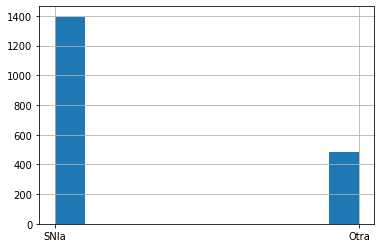

In [10]:
df_SNIa['classALeRCE'].hist()

In [11]:
X = df_SNIa.drop(columns = ['classALeRCE', 'oid'])
X = scaler.fit_transform(X)
y = df_SNIa['classALeRCE'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [12]:
countFreq(y_test, len(y_test))

SNIa 432
Otra 131


In [13]:
#Ahora convertiremos nuestras variables objetivo en categorias, para poder entrenar nuestro modelo, puesto que keras no acepta variables numericas como variables objetivo para clasificacion.
y_train = pd.get_dummies(y_train, columns = ['classALeRCE'])
y_test = pd.get_dummies(y_test, columns = ['classALeRCE'])

In [14]:
modelo_tarea = mi_red(num_hidden_layers = 2, 
                   num_neurons_per_layer = [40,40], 
                   dropout_rate = 0.1, 
                   activation = 'relu',
                   n_var = X_train)
modelo_tarea.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 107)]             0         
                                                                 
 dropout (Dropout)           (None, 107)               0         
                                                                 
 dense (Dense)               (None, 40)                4320      
                                                                 
 dropout_1 (Dropout)         (None, 40)                0         
                                                                 
 dense_1 (Dense)             (None, 40)                1640      
                                                                 
 dropout_2 (Dropout)         (None, 40)                0         
                                                                 
 dense_2 (Dense)             (None, 2)                 82    

In [15]:
# Se plantea un método de regularización como un early stopper.
early_stopping_monitor = EarlyStopping(patience = 10)

# Se utiliza un optimizador como Adam, con el learning rate indicado.
optimizer = tf.keras.optimizers.SGD(learning_rate = 0.01)

# Se compila el modelo, donde se plantea un binary_crossentropy debido al tipo de problema. Y se utiliza la métrica correspondiente binary_accuracy y recall dado el desbalanceo de datos.
modelo_tarea.compile(loss = 'binary_crossentropy', optimizer = optimizer, metrics = ['Recall'])

# Se entrena la red, con una cantidad de épocas máxima de 100, en general se detiene antes por el early_stopper. Además, se utiliza un batch de 128.
history_tarea = modelo_tarea.fit(X_train, y_train, validation_data = (X_test, y_test), epochs = 1000, verbose = 1, batch_size = 128, callbacks= early_stopping_monitor)

Epoch 1/1000
11/11 [==============================] - 3s 27ms/step - loss: 0.6836 - recall: 0.6024 - val_loss: 0.6538 - val_recall: 0.6625
Epoch 2/1000
11/11 [==============================] - 0s 6ms/step - loss: 0.6590 - recall: 0.6451 - val_loss: 0.6408 - val_recall: 0.6980
Epoch 3/1000
11/11 [==============================] - 0s 6ms/step - loss: 0.6420 - recall: 0.6573 - val_loss: 0.6297 - val_recall: 0.7282
Epoch 4/1000
11/11 [==============================] - 0s 6ms/step - loss: 0.6370 - recall: 0.6801 - val_loss: 0.6192 - val_recall: 0.7460
Epoch 5/1000
11/11 [==============================] - 0s 6ms/step - loss: 0.6363 - recall: 0.7007 - val_loss: 0.6096 - val_recall: 0.7567
Epoch 6/1000
11/11 [==============================] - 0s 7ms/step - loss: 0.6242 - recall: 0.7068 - val_loss: 0.6011 - val_recall: 0.7602
Epoch 7/1000
11/11 [==============================] - 0s 6ms/step - loss: 0.6179 - recall: 0.7030 - val_loss: 0.5929 - val_recall: 0.7709
Epoch 8/1000
11/11 [=============

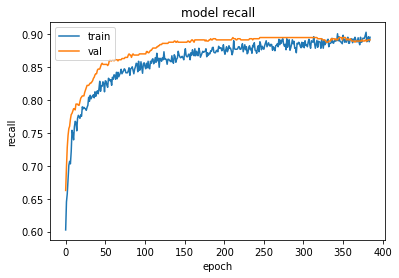

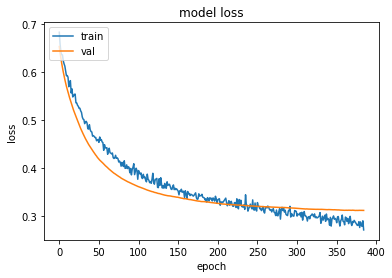

In [16]:
# Se procede a graficar las iteraciones.

f1 = graficos_entreno('recall', history_tarea)
plt.show()


f4 = graficos_entreno('loss', history_tarea)
plt.show()

In [17]:
y_testeo = y_test.to_numpy()
predictions = modelo_tarea.predict(
      x=X_test
    , batch_size=10
    , verbose=0
)

In [18]:
modelo_tarea.get_layer

<bound method Model.get_layer of <keras.engine.functional.Functional object at 0x7fe0a0371c70>>

18/18 [==============================] - 0s 2ms/step
Classification report MLP
              precision    recall  f1-score   support

           0       0.85      0.63      0.72       131
           1       0.90      0.97      0.93       432

    accuracy                           0.89       563
   macro avg       0.87      0.80      0.83       563
weighted avg       0.89      0.89      0.88       563

Normalized confusion matrix


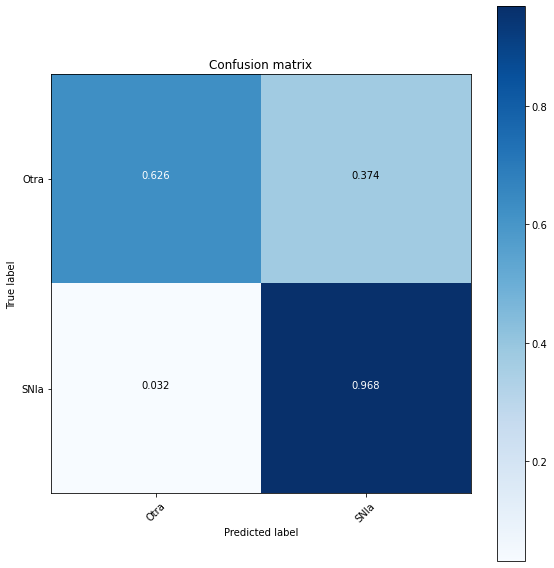

In [19]:
y_predict = modelo_tarea.predict(X_test)

y_test = y_test.to_numpy()
y_test = y_test.astype('float32')

y_test_classes = y_test.argmax(1)
y_pred_classes = y_predict.argmax(1)

# Comparamos con classification_report
print('Classification report MLP')
print(classification_report(y_test_classes, y_pred_classes))

cm = confusion_matrix(y_test_classes, y_pred_classes)
plot_confusion_matrix(cm, ['Otra', 'SNIa'], normalize=True) 

# Modelo para clase SNIbc

In [20]:
df_SNIbc = df_copy.copy()
df_SNIbc.replace({"SNIa": 'Otra', "SNII": 'Otra', "SLSN": 'Otra'}, inplace = True)

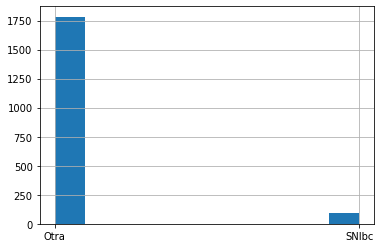

In [21]:
df_SNIbc['classALeRCE'].hist()

In [22]:
X = df_SNIbc.drop(columns = ['classALeRCE', 'oid'])
X = scaler.fit_transform(X)
y = df_SNIbc['classALeRCE'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [23]:
countFreq(y_test, len(y_test))

Otra 591
SNIbc 29


In [24]:
#Ahora convertiremos nuestras variables objetivo en categorias, para poder entrenar nuestro modelo, puesto que keras no acepta variables numericas como variables objetivo para clasificacion.
y_train = pd.get_dummies(y_train, columns = ['classALeRCE'])
y_test = pd.get_dummies(y_test, columns = ['classALeRCE'])

In [25]:
modelo_tarea = mi_red(num_hidden_layers = 2, 
                   num_neurons_per_layer = [40,40], 
                   dropout_rate = 0.1, 
                   activation = 'relu',
                   n_var = X_train)
modelo_tarea.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 107)]             0         
                                                                 
 dropout_3 (Dropout)         (None, 107)               0         
                                                                 
 dense_3 (Dense)             (None, 40)                4320      
                                                                 
 dropout_4 (Dropout)         (None, 40)                0         
                                                                 
 dense_4 (Dense)             (None, 40)                1640      
                                                                 
 dropout_5 (Dropout)         (None, 40)                0         
                                                                 
 dense_5 (Dense)             (None, 2)                 82  

In [26]:
# Se plantea un método de regularización como un early stopper.
early_stopping_monitor = EarlyStopping(patience = 10)

# Se utiliza un optimizador como Adam, con el learning rate indicado.
optimizer = tf.keras.optimizers.SGD(learning_rate = 0.01)

# Se compila el modelo, donde se plantea un binary_crossentropy debido al tipo de problema. Y se utiliza la métrica correspondiente binary_accuracy y recall dado el desbalanceo de datos.
modelo_tarea.compile(loss = 'binary_crossentropy', optimizer = optimizer, metrics = ['Recall'])

# Se entrena la red, con una cantidad de épocas máxima de 100, en general se detiene antes por el early_stopper. Además, se utiliza un batch de 256.
history_tarea = modelo_tarea.fit(X_train, y_train, validation_data = (X_test, y_test), epochs = 1000, verbose = 1, batch_size = 128, callbacks= early_stopping_monitor)

Epoch 1/1000
10/10 [==============================] - 1s 27ms/step - loss: 0.3865 - recall: 0.9546 - val_loss: 0.3801 - val_recall: 0.9548
Epoch 2/1000
10/10 [==============================] - 0s 6ms/step - loss: 0.3591 - recall: 0.9482 - val_loss: 0.3567 - val_recall: 0.9548
Epoch 3/1000
10/10 [==============================] - 0s 6ms/step - loss: 0.3350 - recall: 0.9467 - val_loss: 0.3380 - val_recall: 0.9548
Epoch 4/1000
10/10 [==============================] - 0s 6ms/step - loss: 0.3211 - recall: 0.9482 - val_loss: 0.3227 - val_recall: 0.9532
Epoch 5/1000
10/10 [==============================] - 0s 6ms/step - loss: 0.3061 - recall: 0.9490 - val_loss: 0.3095 - val_recall: 0.9532
Epoch 6/1000
10/10 [==============================] - 0s 7ms/step - loss: 0.2945 - recall: 0.9490 - val_loss: 0.2987 - val_recall: 0.9532
Epoch 7/1000
10/10 [==============================] - 0s 8ms/step - loss: 0.2855 - recall: 0.9475 - val_loss: 0.2896 - val_recall: 0.9532
Epoch 8/1000
10/10 [=============

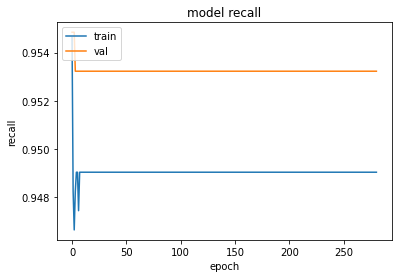

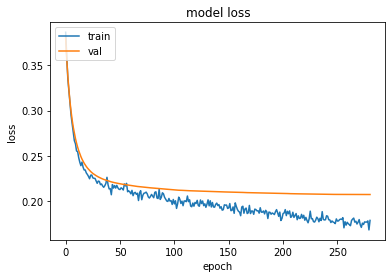

In [27]:
# Se procede a graficar las iteraciones.

f1 = graficos_entreno('recall', history_tarea)
plt.show()


f4 = graficos_entreno('loss', history_tarea)
plt.show()

In [28]:
y_testeo = y_test.to_numpy()
predictions = modelo_tarea.predict(
      x=X_test
    , batch_size=10
    , verbose=0
)

0: "SNIbc"

1: "Otra"

20/20 [==============================] - 0s 1ms/step
Classification report MLP
              precision    recall  f1-score   support

           0       0.95      1.00      0.98       591
           1       0.00      0.00      0.00        29

    accuracy                           0.95       620
   macro avg       0.48      0.50      0.49       620
weighted avg       0.91      0.95      0.93       620

Normalized confusion matrix


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


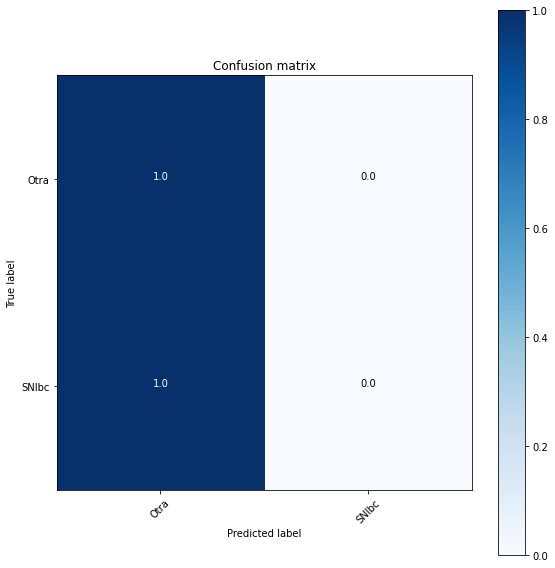

In [29]:
y_predict = modelo_tarea.predict(X_test)

y_test = y_test.to_numpy()
y_test = y_test.astype('float32')

y_test_classes = y_test.argmax(1)
y_pred_classes = y_predict.argmax(1)

# Comparamos con classification_report
print('Classification report MLP')
print(classification_report(y_test_classes, y_pred_classes))

cm = confusion_matrix(y_test_classes, y_pred_classes)
plot_confusion_matrix(cm, ['Otra', 'SNIbc'], normalize=True) 

# Modelo para clase SNII

In [30]:
df_SNII = df_copy.copy()
df_SNII.replace({"SNIa": 'Otra', "SNIbc": 'Otra', "SLSN": 'Otra'}, inplace = True)

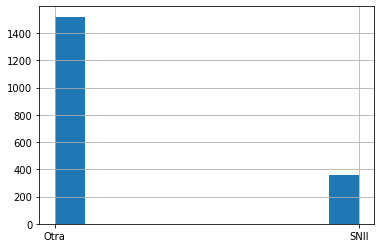

In [31]:
df_SNII['classALeRCE'].hist()

In [32]:
X = df_SNII.drop(columns = ['classALeRCE', 'oid'])
X = scaler.fit_transform(X)
y = df_SNII['classALeRCE'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [33]:
countFreq(y_test, len(y_test))

Otra 506
SNII 114


In [34]:
#Ahora convertiremos nuestras variables objetivo en categorias, para poder entrenar nuestro modelo, puesto que keras no acepta variables numericas como variables objetivo para clasificacion.
y_train = pd.get_dummies(y_train, columns = ['classALeRCE'])
y_test = pd.get_dummies(y_test, columns = ['classALeRCE'])

In [35]:
modelo_tarea = mi_red(num_hidden_layers = 2, 
                   num_neurons_per_layer = [40,40], 
                   dropout_rate = 0.1, 
                   activation = 'relu',
                   n_var = X_train)
modelo_tarea.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 107)]             0         
                                                                 
 dropout_6 (Dropout)         (None, 107)               0         
                                                                 
 dense_6 (Dense)             (None, 40)                4320      
                                                                 
 dropout_7 (Dropout)         (None, 40)                0         
                                                                 
 dense_7 (Dense)             (None, 40)                1640      
                                                                 
 dropout_8 (Dropout)         (None, 40)                0         
                                                                 
 dense_8 (Dense)             (None, 2)                 82  

In [36]:
# Se plantea un método de regularización como un early stopper.
early_stopping_monitor = EarlyStopping(patience = 10)

# Se utiliza un optimizador como Adam, con el learning rate indicado.
optimizer = tf.keras.optimizers.SGD(learning_rate = 0.01)

# Se compila el modelo, donde se plantea un binary_crossentropy debido al tipo de problema. Y se utiliza la métrica correspondiente binary_accuracy y recall dado el desbalanceo de datos.
modelo_tarea.compile(loss = 'binary_crossentropy', optimizer = optimizer, metrics = ['Recall'])

# Se entrena la red, con una cantidad de épocas máxima de 100, en general se detiene antes por el early_stopper. Además, se utiliza un batch de 256.
history_tarea = modelo_tarea.fit(X_train, y_train, validation_data = (X_test, y_test), epochs = 1000, verbose = 1, batch_size = 128, callbacks= early_stopping_monitor)

Epoch 1/1000
10/10 [==============================] - 1s 29ms/step - loss: 0.9586 - recall: 0.1768 - val_loss: 0.8686 - val_recall: 0.1468
Epoch 2/1000
10/10 [==============================] - 0s 6ms/step - loss: 0.8466 - recall: 0.1943 - val_loss: 0.7821 - val_recall: 0.2290
Epoch 3/1000
10/10 [==============================] - 0s 6ms/step - loss: 0.7718 - recall: 0.2938 - val_loss: 0.7194 - val_recall: 0.3500
Epoch 4/1000
10/10 [==============================] - 0s 7ms/step - loss: 0.7087 - recall: 0.3917 - val_loss: 0.6738 - val_recall: 0.4839
Epoch 5/1000
10/10 [==============================] - 0s 7ms/step - loss: 0.6648 - recall: 0.5032 - val_loss: 0.6398 - val_recall: 0.6097
Epoch 6/1000
10/10 [==============================] - 0s 6ms/step - loss: 0.6350 - recall: 0.5780 - val_loss: 0.6140 - val_recall: 0.6726
Epoch 7/1000
10/10 [==============================] - 0s 7ms/step - loss: 0.6062 - recall: 0.6401 - val_loss: 0.5938 - val_recall: 0.7145
Epoch 8/1000
10/10 [=============

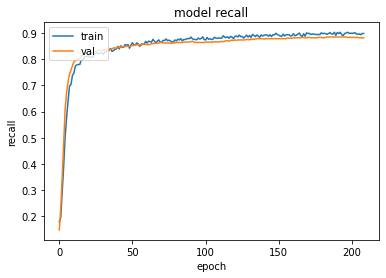

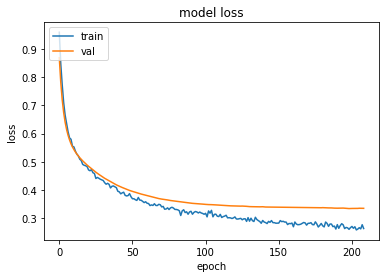

In [37]:
# Se procede a graficar las iteraciones.

f1 = graficos_entreno('recall', history_tarea)
plt.show()


f4 = graficos_entreno('loss', history_tarea)
plt.show()

In [38]:
y_testeo = y_test.to_numpy()
predictions = modelo_tarea.predict(
      x=X_test
    , batch_size=10
    , verbose=0
)

0: "SNII"

1: "Otra"

20/20 [==============================] - 0s 2ms/step
Classification report MLP
              precision    recall  f1-score   support

           0       0.89      0.97      0.93       506
           1       0.77      0.49      0.60       114

    accuracy                           0.88       620
   macro avg       0.83      0.73      0.76       620
weighted avg       0.87      0.88      0.87       620

Normalized confusion matrix


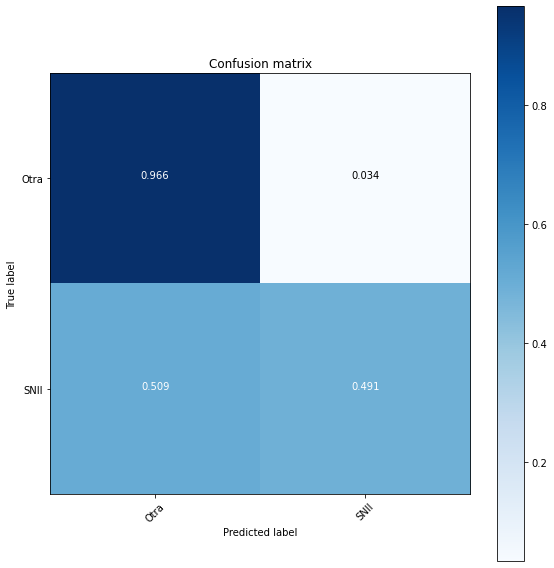

In [39]:
y_predict = modelo_tarea.predict(X_test)

y_test = y_test.to_numpy()
y_test = y_test.astype('float32')

y_test_classes = y_test.argmax(1)
y_pred_classes = y_predict.argmax(1)

# Comparamos con classification_report
print('Classification report MLP')
print(classification_report(y_test_classes, y_pred_classes))

cm = confusion_matrix(y_test_classes, y_pred_classes)
plot_confusion_matrix(cm, ['Otra', 'SNII'], normalize=True) 

# Modelo para clase SLSN

In [40]:
df_SLSN = df_copy.copy()
df_SLSN.replace({"SNIa": 'Otra', "SNIbc": 'Otra', "SNII": 'Otra'}, inplace = True)

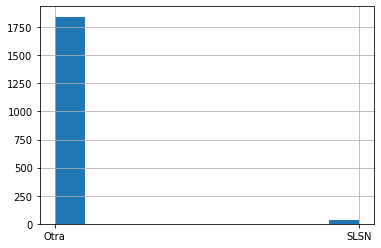

In [41]:
df_SLSN['classALeRCE'].hist()

In [42]:
X = df_SLSN.drop(columns = ['classALeRCE', 'oid'])
X = scaler.fit_transform(X)
y = df_SLSN['classALeRCE'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [43]:
countFreq(y_test, len(y_test))

Otra 614
SLSN 6


In [44]:
#Ahora convertiremos nuestras variables objetivo en categorias, para poder entrenar nuestro modelo, puesto que keras no acepta variables numericas como variables objetivo para clasificacion.
y_train = pd.get_dummies(y_train, columns = ['classALeRCE'])
y_test = pd.get_dummies(y_test, columns = ['classALeRCE'])

In [45]:
modelo_tarea = mi_red(num_hidden_layers = 2, 
                   num_neurons_per_layer = [40,40], 
                   dropout_rate = 0.1, 
                   activation = 'relu',
                   n_var = X_train)
modelo_tarea.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 107)]             0         
                                                                 
 dropout_9 (Dropout)         (None, 107)               0         
                                                                 
 dense_9 (Dense)             (None, 40)                4320      
                                                                 
 dropout_10 (Dropout)        (None, 40)                0         
                                                                 
 dense_10 (Dense)            (None, 40)                1640      
                                                                 
 dropout_11 (Dropout)        (None, 40)                0         
                                                                 
 dense_11 (Dense)            (None, 2)                 82  

In [46]:
# Se plantea un método de regularización como un early stopper.
early_stopping_monitor = EarlyStopping(patience = 10)

# Se utiliza un optimizador como Adam, con el learning rate indicado.
optimizer = tf.keras.optimizers.SGD(learning_rate = 0.01)

# Se compila el modelo, donde se plantea un binary_crossentropy debido al tipo de problema. Y se utiliza la métrica correspondiente binary_accuracy y recall dado el desbalanceo de datos.
modelo_tarea.compile(loss = 'binary_crossentropy', optimizer = optimizer, metrics = ['Recall'])

# Se entrena la red, con una cantidad de épocas máxima de 100, en general se detiene antes por el early_stopper. Además, se utiliza un batch de 256.
history_tarea = modelo_tarea.fit(X_train, y_train, validation_data = (X_test, y_test), epochs = 1000, verbose = 1, batch_size = 128, callbacks= early_stopping_monitor)

Epoch 1/1000
10/10 [==============================] - 1s 27ms/step - loss: 0.9012 - recall: 0.1545 - val_loss: 0.8189 - val_recall: 0.2242
Epoch 2/1000
10/10 [==============================] - 0s 7ms/step - loss: 0.7485 - recall: 0.3559 - val_loss: 0.6906 - val_recall: 0.4226
Epoch 3/1000
10/10 [==============================] - 0s 6ms/step - loss: 0.6380 - recall: 0.5406 - val_loss: 0.5931 - val_recall: 0.6758
Epoch 4/1000
10/10 [==============================] - 0s 6ms/step - loss: 0.5575 - recall: 0.7221 - val_loss: 0.5163 - val_recall: 0.8565
Epoch 5/1000
10/10 [==============================] - 0s 8ms/step - loss: 0.4896 - recall: 0.8535 - val_loss: 0.4560 - val_recall: 0.9419
Epoch 6/1000
10/10 [==============================] - 0s 6ms/step - loss: 0.4429 - recall: 0.9092 - val_loss: 0.4067 - val_recall: 0.9661
Epoch 7/1000
10/10 [==============================] - 0s 6ms/step - loss: 0.3975 - recall: 0.9403 - val_loss: 0.3672 - val_recall: 0.9823
Epoch 8/1000
10/10 [=============

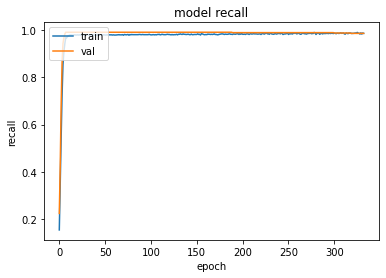

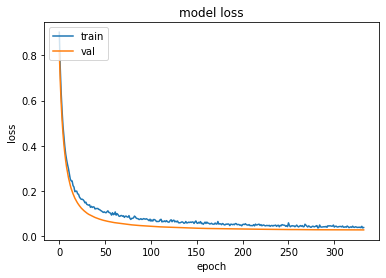

In [47]:
# Se procede a graficar las iteraciones.

f1 = graficos_entreno('recall', history_tarea)
plt.show()


f4 = graficos_entreno('loss', history_tarea)
plt.show()

In [48]:
y_testeo = y_test.to_numpy()
predictions = modelo_tarea.predict(
      x=X_test
    , batch_size=10
    , verbose=0
)

0: "SLSN"

1: "Otra"

20/20 [==============================] - 0s 1ms/step
Classification report MLP
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       614
           1       0.00      0.00      0.00         6

    accuracy                           0.99       620
   macro avg       0.50      0.50      0.50       620
weighted avg       0.98      0.99      0.98       620

Normalized confusion matrix


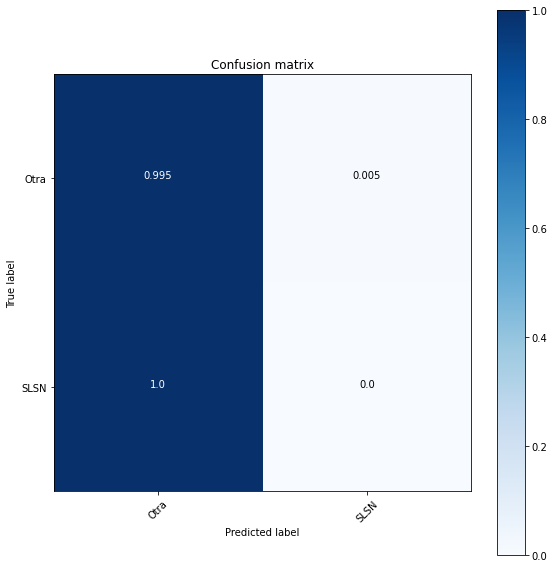

In [49]:
y_predict = modelo_tarea.predict(X_test)

y_test = y_test.to_numpy()
y_test = y_test.astype('float32')

y_test_classes = y_test.argmax(1)
y_pred_classes = y_predict.argmax(1)

# Comparamos con classification_report
print('Classification report MLP')
print(classification_report(y_test_classes, y_pred_classes))

cm = confusion_matrix(y_test_classes, y_pred_classes)
plot_confusion_matrix(cm, ['Otra', 'SLSN'], normalize=True) 

# Modelo para Multiclase

Separamos el dataset en entrenamiento y testeo, además de balancear los datos usando SMOTE 

In [76]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

scaler = StandardScaler()
Le = LabelEncoder()
X = df_copy.drop(columns = ['classALeRCE', 'oid'])
X = scaler.fit_transform(X)
y = df_copy['classALeRCE'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)


#Ahora balanceamos los datos previamente a aplicar los modelos
from imblearn.over_sampling import SMOTE
sm= SMOTE(sampling_strategy = {'SLSN': 600 , 'SNII': 356*3, 'SNIa': 1394, 'SNIbc': 96*8})
X_train_smote, y_train_smote = sm.fit_resample(X_train, y_train)
X_train, y_train = X_train_smote, y_train_smote

/usr/local/lib/python3.8/dist-packages/imblearn/utils/_validation.py:299: UserWarning: After over-sampling, the number of samples (1068) in class SNII will be larger than the number of samples in the majority class (class #SNIa -> 923)
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/imblearn/utils/_validation.py:299: UserWarning: After over-sampling, the number of samples (1394) in class SNIa will be larger than the number of samples in the majority class (class #SNIa -> 923)
  warnings.warn(


In [77]:
countFreq(y_test, len(y_test))

SNIa 471
SNII 114
SNIbc 29
SLSN 6


In [78]:
# Se procede a crear una red neuronal tipo MLP.
def mi_red(num_hidden_layers, 
           num_neurons_per_layer, 
           dropout_rate,
           activation,
           n_var):
  
  # Capa de entrada
  inputs = tf.keras.Input(shape = (n_var.shape[1],))

  x = tf.keras.layers.Dropout(dropout_rate)(inputs) 

  # Capas ocultas
  for i in range(num_hidden_layers):
    x = tf.keras.layers.Dense(num_neurons_per_layer[i], activation = activation)(x)
    
    x = tf.keras.layers.Dropout(dropout_rate)(x)
  
  # Capa de salida

  outputs = tf.keras.layers.Dense(4, activation = 'sigmoid')(x)

  # Se crea el modelo con el input y los outputs.
  model = tf.keras.Model(inputs=inputs, outputs=outputs)

  return model

def graficos_entreno(metrica, h):

  # Se crea la figura.
  f = plt.figure()

  # Se procede a graficar la métrica ingresada.
  plt.plot(h.history[metrica])
  plt.plot(h.history['val_{}'.format(metrica)])

  # Se realizan las anotaciones del gráfico.
  plt.title('model {}'.format(metrica))
  plt.ylabel(metrica)
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  return f

In [79]:
#Ahora convertiremos nuestras variables objetivo en categorias, para poder entrenar nuestro modelo, puesto que keras no acepta variables numericas como variables objetivo para clasificacion.
y_train = pd.get_dummies(y_train, columns = ['classALeRCE'])
y_test = pd.get_dummies(y_test, columns = ['classALeRCE'])

In [80]:
modelo_tarea = mi_red(num_hidden_layers = 4, 
                   num_neurons_per_layer = [30,40, 20, 20], 
                   dropout_rate = 0.1, 
                   activation = 'relu',
                   n_var = X_train)
modelo_tarea.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 107)]             0         
                                                                 
 dropout_22 (Dropout)        (None, 107)               0         
                                                                 
 dense_22 (Dense)            (None, 30)                3240      
                                                                 
 dropout_23 (Dropout)        (None, 30)                0         
                                                                 
 dense_23 (Dense)            (None, 40)                1240      
                                                                 
 dropout_24 (Dropout)        (None, 40)                0         
                                                                 
 dense_24 (Dense)            (None, 20)                820 

In [81]:
# Se plantea un método de regularización como un early stopper.
early_stopping_monitor = EarlyStopping(patience = 10)

# Se utiliza un optimizador como Adam, con el learning rate indicado.
optimizer = tf.keras.optimizers.SGD(learning_rate = 0.01)

# Se compila el modelo, donde se plantea un categorical_crossentropy debido al tipo de problema. Y se utiliza la métrica correspondiente categorical_accuracy y recall dado el desbalanceo de datos.
modelo_tarea.compile(loss = 'categorical_crossentropy', optimizer = optimizer, metrics = ['categorical_accuracy', 'Recall'])

# Se entrena la red, con una cantidad de épocas máxima de 100, en general se detiene antes por el early_stopper. Además, se utiliza un batch de 256.
history_tarea = modelo_tarea.fit(X_train, y_train, validation_data = (X_test, y_test), epochs = 1000, verbose = 1, batch_size = 128, callbacks= early_stopping_monitor)

Epoch 1/1000
30/30 [==============================] - 1s 13ms/step - loss: 1.3932 - categorical_accuracy: 0.3410 - recall: 0.5436 - val_loss: 1.2584 - val_categorical_accuracy: 0.6065 - val_recall: 0.6903
Epoch 2/1000
30/30 [==============================] - 0s 5ms/step - loss: 1.3441 - categorical_accuracy: 0.3708 - recall: 0.5653 - val_loss: 1.1984 - val_categorical_accuracy: 0.6806 - val_recall: 0.7468
Epoch 3/1000
30/30 [==============================] - 0s 4ms/step - loss: 1.3142 - categorical_accuracy: 0.3984 - recall: 0.6089 - val_loss: 1.1541 - val_categorical_accuracy: 0.7161 - val_recall: 0.7871
Epoch 4/1000
30/30 [==============================] - 0s 4ms/step - loss: 1.2808 - categorical_accuracy: 0.4185 - recall: 0.6298 - val_loss: 1.1120 - val_categorical_accuracy: 0.7468 - val_recall: 0.8113
Epoch 5/1000
30/30 [==============================] - 0s 5ms/step - loss: 1.2530 - categorical_accuracy: 0.4305 - recall: 0.6402 - val_loss: 1.0811 - val_categorical_accuracy: 0.7419 

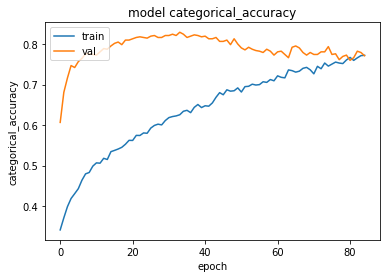

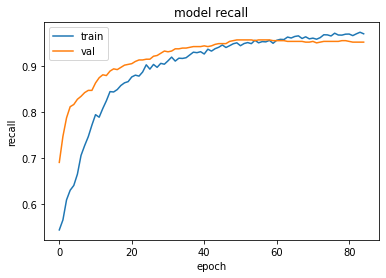

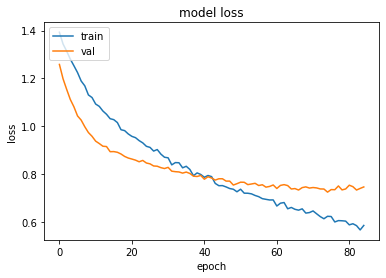

In [82]:
# Se procede a graficar las iteraciones.

f1 = graficos_entreno('categorical_accuracy', history_tarea)
plt.show()

f1 = graficos_entreno('recall', history_tarea)
plt.show()

f4 = graficos_entreno('loss', history_tarea)
plt.show()

In [83]:
y_predict = modelo_tarea.predict(X_test)

20/20 [==============================] - 0s 1ms/step


In [84]:
y_test = y_test.to_numpy()
y_test = y_test.astype('float32')

In [85]:
y_test_classes = y_test.argmax(1)
y_pred_classes = y_predict.argmax(1)

In [86]:
# Comparamos con classification_report
print('Classification report MLP')
print(classification_report(y_test_classes, y_pred_classes))

Classification report MLP
              precision    recall  f1-score   support

           0       0.23      1.00      0.38         6
           1       0.69      0.63      0.66       114
           2       0.92      0.84      0.88       471
           3       0.07      0.14      0.09        29

    accuracy                           0.77       620
   macro avg       0.48      0.65      0.50       620
weighted avg       0.83      0.77      0.80       620



In [87]:
cm = confusion_matrix(y_test_classes, y_pred_classes)

Normalized confusion matrix


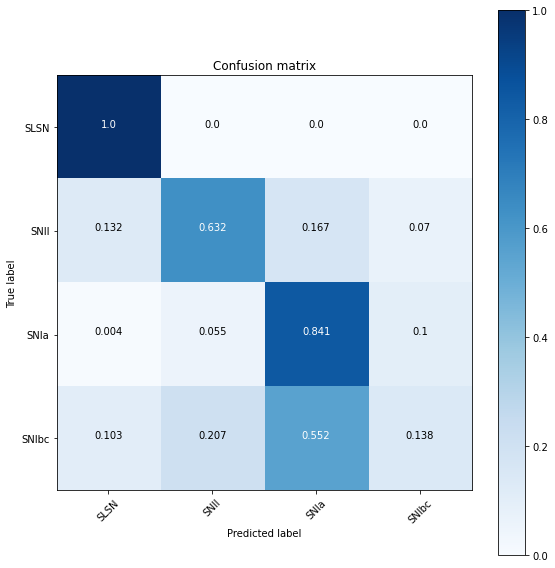

In [88]:
plot_confusion_matrix(cm, ['SLSN', 'SNII', 'SNIa', 'SNIbc'], normalize=True) 